In [1]:
# some jupyter formatting:
from IPython.core.display import HTML
table_css = 'table {align:left;display:block} '
HTML('<style>{}</style>'.format(table_css))

# Introduction

Please find the write-up here: Link

This is the notebook with an example of how to construct multiclass labels from vector boundaries as an alternative to the rasterised method used for RAMP mask creation. The alternative method could solve a few issues regarding YOLO masking:

- contact class could be a string of single cells, and these are treated as individual polygons
- buffers are pixellated, making them (in vector space) heavier than straight lines; the buffers are arcs and can be heavy too, but the lines can be simplified before conversion to YOLO format (not implemented here)

The code has 10 output files, 9 are intermediate products (to test the logic), and the final file is the combined class layer:
- footprint (most inner part)
- boundary (the edge of a building)
- contact (the area where two, or more, buildings are close to eachother)
- outside (the no data area)

Exported files (search for "exporting the file" in the code to find the checkpoints):
| code id      | file name                          | description                                                      |
| :----------- | :----------------------------------| :--------------------------------------------------------------- |
| file_name1   | "gdf_lines_060.geojson"            | Converted buffer polygon, outside                                |
| file_name2   | "gdf_lines_120.geojson"            | Converted buffer polygon, inside                                 |
| file_name3   | "gdf_poly_footprint_120.geojson"   | The inner part of a building footprint                           |
| file_name4   | "gdf_poly_no_building_060.geojson" | The outer part of all building footprints, no data               |
| file_name5   | "gdf_poly_full_outline.geojson"    | The boundery of a building, with in- and outside buffers         |
| file_name6   | "gdf_poly_test1.geojson"           | test data, for verification                                      |
| file_name7   | "gdf_point_test1b.geojson"         | test data, for verification                                      |
| file_name8   | "gdf_poly_060_filtered.geojson"    | the contact polygons, the area overlapped by the outside buffers |
| file_name9   | "gdf_building_boundary.geojson"    | the boundary of a building, with the contact removed             |
| ...          | ...                                | ...                                                              |
| file_name10  | "gdf_multiclass_mask.geojson"      | the combination of files 03, 04, 08, 09                          | <br>



To generate the output file, two files are used:

- AoI: the regions have many chips, and the AoI is the combined extent of all the chips in a region
- labels_epsg3857: these are all the vector labels intersecting the AoI, with full outlines at the edge of the AoI to make the building footprint complete

Both files were delivered as part of a larger package and are the preconditions for this notebook to work correctly.

Libraries: no special geospatial libraries are loaded besides the ones listed in the cell below.



In [ ]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd

from shapely.geometry import MultiPolygon, Polygon, MultiLineString, LineString
from shapely.ops import unary_union, polygonize, polygonize_full

In [ ]:
root_folder = r"Omdena/__HOTOSM/Code"
working_folder = r"MultiMask_20240804"

original_data = r"training_files/training_577/training_577/preprocessed"

labels_epsg3857 = "labels_epsg3857.geojson"
aoi_labels = "aois.geojson"

In [ ]:
data_path = os.path.join(root_folder, working_folder, original_data)
print(data_path)

Omdena/__HOTOSM/Code\MultiMask_20240804\training_files/training_577/training_577/preprocessed


In [ ]:
#handling the Area of Interest (aio)

In [ ]:
label_file = os.path.join(data_path, aoi_labels)
print(label_file)

Omdena/__HOTOSM/Code\MultiMask_20240804\training_files/training_577/training_577/preprocessed\aois.geojson


In [ ]:
gdf_aoi_epsg4326 = gpd.read_file(label_file)

In [ ]:
gdf_aoi_epsg4326

,label_status,label_fetched,created_at,last_modified,dataset,geometry
0,1,2024-04-29 12:39:43.536000+00:00,2024-01-16 12:26:35.812000+00:00,2024-04-29 12:39:43.536000+00:00,58,"POLYGON ((34.82254 3.76971, 34.82254 3.77108, ..."
1,1,2024-01-23 12:35:50.990000+00:00,2024-01-23 12:35:41.883000+00:00,2024-01-23 12:35:50.990000+00:00,58,"POLYGON ((34.82254 3.76765, 34.82254 3.76902, ..."


In [ ]:
#reprojecting to 3857:
gdf_aoi_epsg4326.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
gdf_aoi_epsg3857 = gdf_aoi_epsg4326.to_crs(3857)
gdf_aoi_epsg3857

,label_status,label_fetched,created_at,last_modified,dataset,geometry
0,1,2024-04-29 12:39:43.536000+00:00,2024-01-16 12:26:35.812000+00:00,2024-04-29 12:39:43.536000+00:00,58,"POLYGON ((3876427.452 419945.033, 3876427.452 ..."
1,1,2024-01-23 12:35:50.990000+00:00,2024-01-23 12:35:41.883000+00:00,2024-01-23 12:35:50.990000+00:00,58,"POLYGON ((3876427.452 419715.722, 3876427.452 ..."


In [ ]:
#handling the extended labels:

In [ ]:
label_file = os.path.join(data_path, labels_epsg3857)
print(label_file)

Omdena/__HOTOSM/Code\MultiMask_20240804\training_files/training_577/training_577/preprocessed\labels_epsg3857.geojson


In [ ]:
gdf_labels_epsg3857 = gpd.read_file(label_file)

In [ ]:
gdf_labels_epsg3857.head(5)

,osm_id,tags,geometry
0,1278161394,{'building': 'yes'},"POLYGON ((3876429.002 420061.108, 3876432.085 ..."
1,1201618391,"{'building': 'yes', 'roof:material': 'metal_sh...","POLYGON ((3876495.326 419957.981, 3876497.697 ..."
2,1201618386,"{'building': 'yes', 'roof:material': 'metal_sh...","POLYGON ((3876442.148 419959.934, 3876445.377 ..."
3,699462263,"{'building': 'yes', 'roof:material': 'metal_sh...","POLYGON ((3876479.919 419961.317, 3876481.956 ..."
4,1201618390,"{'building': 'yes', 'roof:material': 'metal_sh...","POLYGON ((3876499.500 419960.726, 3876506.569 ..."


<Axes: >

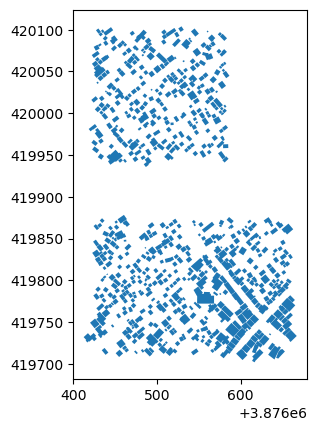

In [ ]:
gdf_labels_epsg3857.plot()

Convert to line

In [ ]:
gdf_lines = gpd.GeoDataFrame(gdf_labels_epsg3857[['osm_id']],geometry=gdf_labels_epsg3857.geometry.boundary)

In [ ]:
# Assuming 'osm_id' is an unique identifier column
gdf_buffer_060 = gdf_lines.groupby('osm_id').apply(lambda x: x.buffer(0.6)).reset_index(level=0)
gdf_buffer_120 = gdf_lines.groupby('osm_id').apply(lambda x: x.buffer(1.2)).reset_index(level=0)

In [ ]:
# convert to line
gdf_lines_060 = gpd.GeoDataFrame(gdf_buffer_060[['osm_id']], geometry=gdf_buffer_060.geometry.boundary)
gdf_lines_120 = gpd.GeoDataFrame(gdf_buffer_120[['osm_id']],geometry=gdf_buffer_120.geometry.boundary)

In [ ]:
# recreate the individual buildings
gdf_lines_060_exp = gdf_lines_060.explode(index_parts=True)
gdf_lines_120_exp = gdf_lines_120.explode(index_parts=True)

In [ ]:
# add a unique identifier, the buffers are dual line (inside and outside), and the construction direction is unknown,
# meaning that looking for the left/right site of the line  doesn't give reliable results, so inside and outside buffer
# lines have to be found differently.

gdf_lines_060_exp_reset = gdf_lines_060_exp.reset_index()
gdf_lines_060_exp_reset = gdf_lines_060_exp_reset.rename(columns={'level_0': 'original_index',
                                                                   'level_1': 'line_part'})
gdf_lines_060_exp_reset

,original_index,line_part,osm_id,geometry
0,321,0,698353461,"LINESTRING (3876433.484 419716.803, 3876436.83..."
1,321,1,698353461,"LINESTRING (3876434.711 419716.260, 3876438.52..."
2,324,0,698526227,"LINESTRING (3876483.894 419716.377, 3876487.24..."
3,324,1,698526227,"LINESTRING (3876485.164 419715.945, 3876491.32..."
4,313,0,698526228,"LINESTRING (3876469.403 419726.865, 3876472.94..."
...,...,...,...,...
1328,76,1,1221944685,"LINESTRING (3876503.785 420057.087, 3876506.94..."
1329,193,0,1221944686,"LINESTRING (3876507.699 420058.393, 3876511.81..."
1330,193,1,1221944686,"LINESTRING (3876508.976 420057.982, 3876510.50..."
1331,0,0,1278161394,"LINESTRING (3876428.587 420061.542, 3876431.96..."


In [ ]:
gdf_lines_120_exp_reset = gdf_lines_120_exp.reset_index()
gdf_lines_120_exp_reset = gdf_lines_120_exp_reset.rename(columns={'level_0': 'original_index',
                                                                   'level_1': 'line_part'})
gdf_lines_120_exp_reset

,original_index,line_part,osm_id,geometry
0,321,0,698353461,"LINESTRING (3876433.102 419717.266, 3876436.45..."
1,321,1,698353461,"LINESTRING (3876435.555 419716.179, 3876438.60..."
2,324,0,698526227,"LINESTRING (3876483.473 419716.804, 3876486.82..."
3,324,1,698526227,"LINESTRING (3876486.012 419715.940, 3876491.32..."
4,313,0,698526228,"LINESTRING (3876468.962 419727.272, 3876472.50..."
...,...,...,...,...
1286,76,1,1221944685,"LINESTRING (3876504.630 420057.005, 3876507.02..."
1287,193,0,1221944686,"LINESTRING (3876507.270 420058.813, 3876511.38..."
1288,193,1,1221944686,"LINESTRING (3876509.825 420057.991, 3876510.49..."
1289,0,0,1278161394,"LINESTRING (3876428.172 420061.976, 3876431.54..."


In [ ]:
data_path = os.path.join(root_folder, working_folder)

file_name1 = "gdf_lines_060.geojson"
file_name2 = "gdf_lines_120.geojson"

file_path1 = os.path.join(data_path, file_name1)
file_path2 = os.path.join(data_path, file_name2)

print(file_path2)

Omdena/__HOTOSM/Code\MultiMask_20240804\gdf_lines_120.geojson


In [ ]:
# exporting the file:
# gdf_lines_060_exp_reset.to_file(file_path1, driver='GeoJSON')
# gdf_lines_120_exp_reset.to_file(file_path2, driver='GeoJSON')

## Filter inside and outside
- precondition: the OSM_ID is a unique ID and is used for simple polygons, e.g., there are no multiplolygons in the label.

Opertations:
- add length to the lines
- when an object (osm_id) has two entries (count), or more, take the longest length as an outside buffer
- if the object only has one entry, and it's the inside buffer (1.2), remove this entry because it's the outside buffer
- for the outside buffer having only one entry is not a problem, this is the outside (0.6)

In [ ]:
gdf_lines_060_exp_reset['length'] = gdf_lines_060_exp_reset.geometry.length
gdf_lines_120_exp_reset['length'] = gdf_lines_120_exp_reset.geometry.length

In [ ]:
gdf_lines_060_exp_reset.head(5)

,original_index,line_part,osm_id,geometry,length
0,321,0,698353461,"LINESTRING (3876433.484 419716.803, 3876436.83...",26.836122
1,321,1,698353461,"LINESTRING (3876434.711 419716.260, 3876438.52...",18.267724
2,324,0,698526227,"LINESTRING (3876483.894 419716.377, 3876487.24...",33.129918
3,324,1,698526227,"LINESTRING (3876485.164 419715.945, 3876491.32...",24.561518
4,313,0,698526228,"LINESTRING (3876469.403 419726.865, 3876472.94...",22.571023


In [ ]:
gdf_lines_060_exp_reset['id_count'] = gdf_lines_060_exp_reset.groupby('osm_id')['osm_id'].transform('count')
gdf_lines_120_exp_reset['id_count'] = gdf_lines_120_exp_reset.groupby('osm_id')['osm_id'].transform('count')

In [ ]:
gdf_lines_060_exp_reset.head(5)

,original_index,line_part,osm_id,geometry,length,id_count
0,321,0,698353461,"LINESTRING (3876433.484 419716.803, 3876436.83...",26.836122,2
1,321,1,698353461,"LINESTRING (3876434.711 419716.260, 3876438.52...",18.267724,2
2,324,0,698526227,"LINESTRING (3876483.894 419716.377, 3876487.24...",33.129918,2
3,324,1,698526227,"LINESTRING (3876485.164 419715.945, 3876491.32...",24.561518,2
4,313,0,698526228,"LINESTRING (3876469.403 419726.865, 3876472.94...",22.571023,2


In [ ]:
#outside buffer:
count_table = gdf_lines_060_exp_reset['id_count'].value_counts()
count_table

2    1332
1       1
Name: id_count, dtype: int64

In [ ]:
# inside buffer:
count_table = gdf_lines_120_exp_reset['id_count'].value_counts()
count_table

2    1244
1      44
3       3
Name: id_count, dtype: int64

In [ ]:
filter_count_3 = gdf_lines_120_exp_reset['id_count'] == 3
gdf_count_3 = gdf_lines_120_exp_reset[filter_count_3]
print(gdf_count_3)

    original_index  line_part     osm_id  \
19             311          0  698526237   
20             311          1  698526237   
21             311          2  698526237   

                                             geometry     length  id_count  
19  LINESTRING (3876509.404 419714.520, 3876515.23...  46.503810         3  
20  LINESTRING (3876511.992 419713.812, 3876515.04...  20.589947         3  
21  LINESTRING (3876519.780 419715.500, 3876519.84...   8.001781         3  


In [ ]:
# The object above is a building with an annex, and in 0.6m the opening
# between the main building and the annex is wide enough to be two lines,
# in buffer 1.2m this opening is too small and the inside of the polygon
# has now two parts


### create the inside building footprint

- this is the large buffer (1.2m) but not the outside, so first
- a new ID is generated, of OSM_ID and line_part,
- then the max lenght per OSM ID is selected, and
- the new ID is used as filter to remove the longest lines from the list
  

In [ ]:
gdf_lines_120_exp_reset['new_ID'] = gdf_lines_120_exp_reset['osm_id'].astype(str) + \
                              '_' + gdf_lines_120_exp_reset['line_part'].astype(str)
gdf_lines_120_exp_reset.head(5)

,original_index,line_part,osm_id,geometry,length,id_count,new_ID
0,321,0,698353461,"LINESTRING (3876433.102 419717.266, 3876436.45...",30.604519,2,698353461_0
1,321,1,698353461,"LINESTRING (3876435.555 419716.179, 3876438.60...",13.467724,2,698353461_1
2,324,0,698526227,"LINESTRING (3876483.473 419716.804, 3876486.82...",36.898315,2,698526227_0
3,324,1,698526227,"LINESTRING (3876486.012 419715.940, 3876491.32...",19.761515,2,698526227_1
4,313,0,698526228,"LINESTRING (3876468.962 419727.272, 3876472.50...",26.339420,2,698526228_0


In [ ]:
def get_max_length_part(group):
    max_length_idx = group['length'].idxmax()
    return group.loc[max_length_idx, 'new_ID']

result_table = gdf_lines_120_exp_reset.groupby('osm_id').apply(get_max_length_part).reset_index(name='new_ID_max_length')

In [ ]:
result_table

,osm_id,new_ID_max_length
0,698353461,698353461_0
1,698526227,698526227_0
2,698526228,698526228_0
3,698526229,698526229_0
4,698526230,698526230_0
...,...,...
662,1205464098,1205464098_0
663,1221944684,1221944684_0
664,1221944685,1221944685_0
665,1221944686,1221944686_0


In [ ]:
filter_exclude = ~gdf_lines_120_exp_reset['new_ID'].isin(result_table['new_ID_max_length'])
gdf_filtered = gdf_lines_120_exp_reset[filter_exclude]
gdf_filtered

,original_index,line_part,osm_id,geometry,length,id_count,new_ID
1,321,1,698353461,"LINESTRING (3876435.555 419716.179, 3876438.60...",13.467724,2,698353461_1
3,324,1,698526227,"LINESTRING (3876486.012 419715.940, 3876491.32...",19.761515,2,698526227_1
5,313,1,698526228,"LINESTRING (3876471.539 419726.529, 3876472.83...",9.202606,2,698526228_1
7,501,1,698526229,"LINESTRING (3876463.775 419733.168, 3876466.17...",12.631110,2,698526229_1
9,385,1,698526230,"LINESTRING (3876471.517 419733.438, 3876473.02...",12.932676,2,698526230_1
...,...,...,...,...,...,...,...
1282,297,1,1205464098,"LINESTRING (3876634.628 419775.490, 3876636.27...",7.668208,2,1205464098_1
1284,77,1,1221944684,"LINESTRING (3876497.278 420052.968, 3876500.23...",18.460501,2,1221944684_1
1286,76,1,1221944685,"LINESTRING (3876504.630 420057.005, 3876507.02...",10.683841,2,1221944685_1
1288,193,1,1221944686,"LINESTRING (3876509.825 420057.991, 3876510.49...",8.840297,2,1221944686_1


In [ ]:
# Group by OSM_ID and polygonize each group
gdf_polygons_list = []
for osm_id, group in gdf_filtered.groupby('osm_id'):
    lines = group.geometry.unary_union
    polygons = list(polygonize(lines))
    for polygon in polygons:
        gdf_polygons_list.append({'OSM_ID': osm_id, 'geometry': polygon})

# Create a new GeoDataFrame with the polygons and OSM_ID
gdf_poly_footprint = gpd.GeoDataFrame(gdf_polygons_list, crs=gdf_filtered.crs)

In [ ]:
gdf_poly_footprint

,OSM_ID,geometry
0,698353461,"POLYGON ((3876435.555 419716.179, 3876437.055 ..."
1,698526227,"POLYGON ((3876486.012 419715.940, 3876487.657 ..."
2,698526228,"POLYGON ((3876471.539 419726.529, 3876473.458 ..."
3,698526229,"POLYGON ((3876463.775 419733.168, 3876465.729 ..."
4,698526230,"POLYGON ((3876471.517 419733.438, 3876474.660 ..."
...,...,...
619,1205464098,"POLYGON ((3876634.628 419775.490, 3876635.588 ..."
620,1221944684,"POLYGON ((3876497.278 420052.968, 3876500.728 ..."
621,1221944685,"POLYGON ((3876504.630 420057.005, 3876505.848 ..."
622,1221944686,"POLYGON ((3876509.825 420057.991, 3876512.264 ..."


In [ ]:
data_path = os.path.join(root_folder, working_folder)

file_name3 = "gdf_poly_footprint_120.geojson"

file_path3 = os.path.join(data_path, file_name3)

print(file_path3)

Omdena/__HOTOSM/Code\MultiMask_20240804\gdf_poly_footprint_120.geojson


In [ ]:
# exporting the file:
#gdf_poly_footprint.to_file(file_path3, driver='GeoJSON')

## Exporting the outer polygon ##

- This is the AoI polygon intersected with the outer buffer line <br>
<br>
To create the outer buffer line, we need to:
- take the outer buffer lines (0.6) and select the largest line, but
- instead of excluding the lines, these lines are the outer perimeter,
- "no building" in the mask
- when the lines are selected they can be merged with the boundary of the AoI
- this gives potentially an overshoot at the border of the AoI, but
- by clipping to the AoI this overshoot is removed


In [ ]:
gdf_lines_060_exp_reset['new_ID'] = gdf_lines_060_exp_reset['osm_id'].astype(str) + \
                              '_' + gdf_lines_060_exp_reset['line_part'].astype(str)
gdf_lines_060_exp_reset.head(5)

,original_index,line_part,osm_id,geometry,length,id_count,new_ID
0,321,0,698353461,"LINESTRING (3876433.484 419716.803, 3876436.83...",26.836122,2,698353461_0
1,321,1,698353461,"LINESTRING (3876434.711 419716.260, 3876438.52...",18.267724,2,698353461_1
2,324,0,698526227,"LINESTRING (3876483.894 419716.377, 3876487.24...",33.129918,2,698526227_0
3,324,1,698526227,"LINESTRING (3876485.164 419715.945, 3876491.32...",24.561518,2,698526227_1
4,313,0,698526228,"LINESTRING (3876469.403 419726.865, 3876472.94...",22.571023,2,698526228_0


In [ ]:
result_table = gdf_lines_060_exp_reset.groupby('osm_id').apply(get_max_length_part).reset_index(name='new_ID_max_length')

In [ ]:
result_table

,osm_id,new_ID_max_length
0,698353461,698353461_0
1,698526227,698526227_0
2,698526228,698526228_0
3,698526229,698526229_0
4,698526230,698526230_0
...,...,...
662,1205464098,1205464098_0
663,1221944684,1221944684_0
664,1221944685,1221944685_0
665,1221944686,1221944686_0


In [ ]:
filter_include = gdf_lines_060_exp_reset['new_ID'].isin(result_table['new_ID_max_length'])
gdf_filtered = gdf_lines_060_exp_reset[filter_include]
gdf_filtered

gdf_lines_060_filtered = gdf_filtered.copy() # we need this layer later.

In [ ]:
gdf_aoi_epsg3857

,label_status,label_fetched,created_at,last_modified,dataset,geometry
0,1,2024-04-29 12:39:43.536000+00:00,2024-01-16 12:26:35.812000+00:00,2024-04-29 12:39:43.536000+00:00,58,"POLYGON ((3876427.452 419945.033, 3876427.452 ..."
1,1,2024-01-23 12:35:50.990000+00:00,2024-01-23 12:35:41.883000+00:00,2024-01-23 12:35:50.990000+00:00,58,"POLYGON ((3876427.452 419715.722, 3876427.452 ..."


In [ ]:
# Group by OSM_ID and polygonize each group
gdf_polygons_list = []
for osm_id, group in gdf_filtered.groupby('osm_id'):
    lines = group.geometry.unary_union
    polygons = list(polygonize(lines))
    for polygon in polygons:
        gdf_polygons_list.append({'OSM_ID': osm_id, 'geometry': polygon})

# Create a new GeoDataFrame with the polygons and OSM_ID
gdf_polygons = gpd.GeoDataFrame(gdf_polygons_list, crs=gdf_filtered.crs)

In [ ]:
gdf_polygons

,OSM_ID,geometry
0,698353461,"POLYGON ((3876433.484 419716.803, 3876436.835 ..."
1,698526227,"POLYGON ((3876483.894 419716.377, 3876487.245 ..."
2,698526228,"POLYGON ((3876469.403 419726.865, 3876472.943 ..."
3,698526229,"POLYGON ((3876461.704 419733.795, 3876465.512 ..."
4,698526230,"POLYGON ((3876469.426 419733.993, 3876474.368 ..."
...,...,...
662,1205464098,"POLYGON ((3876632.555 419776.108, 3876635.361 ..."
663,1221944684,"POLYGON ((3876495.219 420053.592, 3876500.495 ..."
664,1221944685,"POLYGON ((3876502.559 420057.634, 3876505.632 ..."
665,1221944686,"POLYGON ((3876507.699 420058.393, 3876511.818 ..."


In [ ]:
#res_symdiff = df1.overlay(df2, how='symmetric_difference')

res_symdiff = gdf_aoi_epsg3857.overlay(gdf_polygons, how='symmetric_difference')

<Axes: >

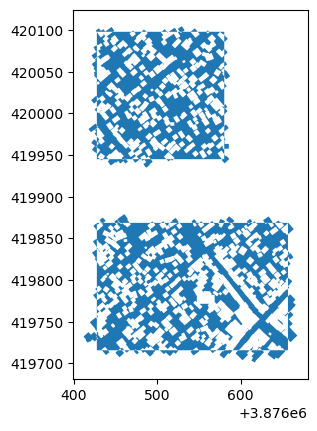

In [ ]:
res_symdiff.plot()

<Axes: >

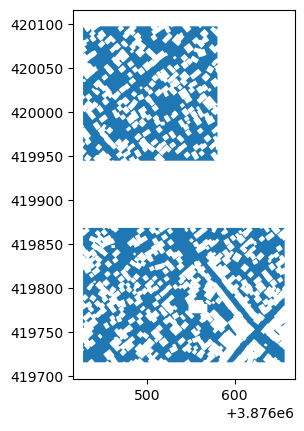

In [ ]:
res_intersection = res_symdiff.overlay(gdf_aoi_epsg3857, how='intersection', keep_geom_type=True)
res_intersection.plot()

In [ ]:
data_path = os.path.join(root_folder, working_folder)

file_name4 = "gdf_poly_no_building_060.geojson"

file_path4 = os.path.join(data_path, file_name4)

print(file_path4)

Omdena/__HOTOSM/Code\MultiMask_20240804\gdf_poly_no_building_060.geojson


In [ ]:
# exporting the file:
#res_intersection.to_file(file_path4, driver='GeoJSON')

### creating the perimeter of the buiding
This is the extraction of the building footprint (1.2 buffer) from the no building area (0.6)

- First the inverse is created using the no-building layer and the AoI, this gives a full polygon of extended buildings,
- Then the reduced footprints are extracted from this layer


In [ ]:
res_symdiff = gdf_aoi_epsg3857.overlay(res_intersection, how='symmetric_difference')

<Axes: >

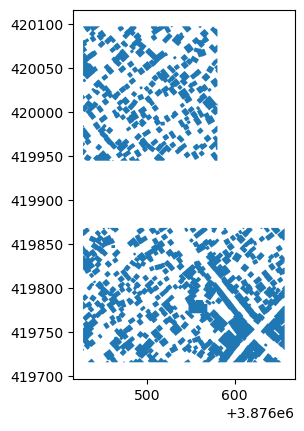

In [ ]:
res_symdiff.plot()

In [ ]:
res_symdiff2 = res_symdiff.overlay(gdf_poly_footprint, how='symmetric_difference') #poly_footprint

In [ ]:
valid_merges_gdf = res_symdiff2[res_symdiff2['label_status'].notna()]

<Axes: >

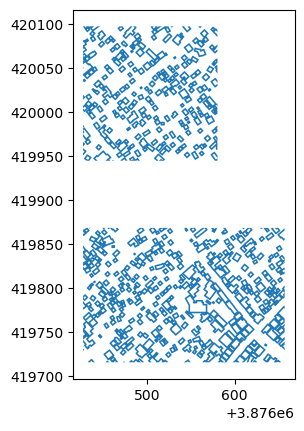

In [ ]:
valid_merges_gdf.plot()

In [ ]:
data_path = os.path.join(root_folder, working_folder)

file_name5 = "gdf_poly_full_outline.geojson"

file_path5 = os.path.join(data_path, file_name5)

print(file_path5)

Omdena/__HOTOSM/Code\MultiMask_20240804\gdf_poly_full_outline.geojson


In [ ]:
# exporting the file:
#valid_merges_gdf.to_file(file_path5, driver='GeoJSON')

## Building Proximity

This is the area overlapping area of two outside buffers as part of the total bourder of the building (the combination of the inner and outer buffer)

To find this overlapping area of the buffer we have to take a few steps, first:
- create a polynized layer of the outside buffer
- create a point at the centre of this area
- spatially join the point to the buffer polygons
- the Area ID with a count larger than 1 in the joined buffers is the poximity area

In [ ]:
# get the lines for the buffer:


In [ ]:
gdf_lines_060_filtered

,original_index,line_part,osm_id,geometry,length,id_count,new_ID
0,321,0,698353461,"LINESTRING (3876433.484 419716.803, 3876436.83...",26.836122,2,698353461_0
2,324,0,698526227,"LINESTRING (3876483.894 419716.377, 3876487.24...",33.129918,2,698526227_0
4,313,0,698526228,"LINESTRING (3876469.403 419726.865, 3876472.94...",22.571023,2,698526228_0
6,501,0,698526229,"LINESTRING (3876461.704 419733.795, 3876465.51...",25.999508,2,698526229_0
8,385,0,698526230,"LINESTRING (3876469.426 419733.993, 3876474.36...",26.301075,2,698526230_0
...,...,...,...,...,...,...,...
1323,297,0,1205464098,"LINESTRING (3876632.555 419776.108, 3876635.36...",21.036610,2,1205464098_0
1325,77,0,1221944684,"LINESTRING (3876495.219 420053.592, 3876500.49...",31.830282,2,1221944684_0
1327,76,0,1221944685,"LINESTRING (3876502.559 420057.634, 3876505.63...",24.052248,2,1221944685_0
1329,193,0,1221944686,"LINESTRING (3876507.699 420058.393, 3876511.81...",22.208695,2,1221944686_0


In [ ]:
# create the contact polygons from the lines:
# by first performing the union all overlapping buffer lines are broken on the intersection, creating rings of buffer
# lines, and then using polygonize will make new polygons of the intersected buffers.

gdf_unary_union = unary_union(gdf_lines_060_filtered.geometry)
geo_poly_060 = polygonize(gdf_unary_union)

In [ ]:
#list(gdf_poly_060)
len(list(geo_poly_060))

1247

In [ ]:
result, cuts, dangles, invalids = polygonize_full(gdf_unary_union)

In [ ]:
len(result.geoms)

1247

In [ ]:
result

In [ ]:
gdf_poly_060 = gpd.GeoDataFrame(geometry=list(geo_poly_060), crs=gdf_filtered.crs)

In [ ]:
gdf_poly_060.reset_index(inplace=True)
gdf_poly_060

,index,geometry
0,0,"POLYGON ((3876433.484 419716.803, 3876436.835 ..."
1,1,"POLYGON ((3876483.894 419716.377, 3876484.191 ..."
2,2,"POLYGON ((3876484.191 419716.671, 3876483.894 ..."
3,3,"POLYGON ((3876484.191 419716.671, 3876487.245 ..."
4,4,"POLYGON ((3876489.395 419718.367, 3876495.096 ..."
...,...,...
1242,1242,"POLYGON ((3876619.843 419766.333, 3876623.996 ..."
1243,1243,"POLYGON ((3876624.491 419771.850, 3876624.514 ..."
1244,1244,"POLYGON ((3876495.219 420053.592, 3876500.495 ..."
1245,1245,"POLYGON ((3876502.559 420057.634, 3876505.632 ..."


In [ ]:
data_path = os.path.join(root_folder, working_folder)

file_name6 = "gdf_poly_test1.geojson"

file_path6 = os.path.join(data_path, file_name6)

print(file_path6)

Omdena/__HOTOSM/Code\MultiMask_20240804\gdf_poly_test1.geojson


In [ ]:
# exporting the file
#gdf_poly_060.to_file(file_path6, driver='GeoJSON')

### Creating the points
the dataframe we created in the previous cells are a full conversion from the lines to the polygons, including the area inside of the ring. For the next strep a point features is needed at the gravitational centre of the polygon.

In [ ]:
# # copy GeoDataFrame
gdf_point_060 = gdf_poly_060.copy()
# # change geometry
# gdf_point_060['geometry'] =gdf_point_060['geometry'].centroid
# gdf_point_060.head()

gdf_point_060 = gdf_point_060.representative_point()
gdf_point_060= gpd.GeoDataFrame(geometry=gdf_point_060)
gdf_point_060 = gpd.sjoin(gdf_point_060, gdf_poly_060, how='left', predicate='within')
gdf_point_060.head(5)

,geometry,index_right,index
0,POINT (3876437.829 419714.952),0,0
1,POINT (3876484.625 419715.351),1,1
2,POINT (3876482.186 419715.551),2,2
3,POINT (3876489.542 419713.411),3,3
4,POINT (3876492.165 419714.944),4,4


In [ ]:
gdf_point_060 = gdf_point_060.drop(columns=['index_right'])
print(gdf_point_060.head(5))
len(gdf_point_060)

                         geometry  index
0  POINT (3876437.829 419714.952)      0
1  POINT (3876484.625 419715.351)      1
2  POINT (3876482.186 419715.551)      2
3  POINT (3876489.542 419713.411)      3
4  POINT (3876492.165 419714.944)      4


1247

In [ ]:
data_path = os.path.join(root_folder, working_folder)

file_name7 = "gdf_point_test1b.geojson"

file_path7 = os.path.join(data_path, file_name7)

print(file_path7)

Omdena/__HOTOSM/Code\MultiMask_20240804\gdf_point_test1b.geojson


In [ ]:
# exporting the file:
#gdf_point_060.to_file(file_path7, driver='GeoJSON')

### creating the spatial join
with the points generated, and an index available it is possible to create a spatial join as an 1 to n relation between the point and buffers under this point

In [ ]:
# the original polygons:
gdf_buffer_060

,osm_id,0
321,698353461,"POLYGON ((3876433.484 419716.803, 3876436.835 ..."
324,698526227,"POLYGON ((3876483.894 419716.377, 3876487.245 ..."
313,698526228,"POLYGON ((3876469.403 419726.865, 3876472.943 ..."
501,698526229,"POLYGON ((3876461.704 419733.795, 3876465.512 ..."
385,698526230,"POLYGON ((3876469.426 419733.993, 3876474.368 ..."
...,...,...
297,1205464098,"POLYGON ((3876632.555 419776.108, 3876635.361 ..."
77,1221944684,"POLYGON ((3876495.219 420053.592, 3876500.495 ..."
76,1221944685,"POLYGON ((3876502.559 420057.634, 3876505.632 ..."
193,1221944686,"POLYGON ((3876507.699 420058.393, 3876511.818 ..."


In [ ]:
overlapping_buffers_gdf = gpd.sjoin(gdf_point_060, gdf_buffer_060,
                how='inner', predicate='within',
                lsuffix="left",
                rsuffix="right")

In [ ]:
overlapping_buffers_gdf.head(10)

,geometry,index,index_right,osm_id
1,POINT (3876484.625 419715.351),1,324,698526227
4,POINT (3876492.165 419714.944),4,324,698526227
1,POINT (3876484.625 419715.351),1,663,1204740573
4,POINT (3876492.165 419714.944),4,288,698526234
7,POINT (3876473.186 419730.150),7,313,698526228
7,POINT (3876473.186 419730.150),7,385,698526230
12,POINT (3876469.596 419732.902),12,385,698526230
13,POINT (3876476.570 419736.369),13,385,698526230
15,POINT (3876478.055 419734.935),15,385,698526230
17,POINT (3876476.784 419733.280),17,385,698526230


In [ ]:
len(overlapping_buffers_gdf)

1190

#### create a count of index
The Spatial join is set on the buffer, so all counts are valid, and points not inside the buffer are removed

In [ ]:
overlapping_buffers_gdf['id_count'] = overlapping_buffers_gdf.groupby('index_right')['index_right'].transform('count')

In [ ]:
overlapping_buffers_gdf

,geometry,index,index_right,osm_id,id_count
1,POINT (3876484.625 419715.351),1,324,698526227,2
4,POINT (3876492.165 419714.944),4,324,698526227,2
1,POINT (3876484.625 419715.351),1,663,1204740573,1
4,POINT (3876492.165 419714.944),4,288,698526234,1
7,POINT (3876473.186 419730.150),7,313,698526228,1
...,...,...,...,...,...
1236,POINT (3876613.035 419756.543),1236,601,1205441630,3
1238,POINT (3876610.654 419754.096),1238,601,1205441630,3
1239,POINT (3876613.844 419751.036),1239,601,1205441630,3
1242,POINT (3876622.113 419768.595),1242,348,1205464093,1


In [ ]:
count_table = overlapping_buffers_gdf['id_count'].value_counts()
count_table

# To clarify, there are 28 polygons with 7 points in the buffer around a building, and
# 234 polygons were only broken once by a buffer intersection

2    238
1    234
3    219
4    164
5    145
6     78
8     48
9     36
7     28
Name: id_count, dtype: int64

In [ ]:
# Drop duplicate points based on their geometry
points_in_polygons_unique = overlapping_buffers_gdf.drop_duplicates(subset='geometry')

In [ ]:
points_in_polygons_unique

# this is the list we can use to filter the proximity (contact) polygon

,geometry,index,index_right,osm_id,id_count
1,POINT (3876484.625 419715.351),1,324,698526227,2
4,POINT (3876492.165 419714.944),4,324,698526227,2
7,POINT (3876473.186 419730.150),7,313,698526228,1
12,POINT (3876469.596 419732.902),12,385,698526230,5
13,POINT (3876476.570 419736.369),13,385,698526230,5
...,...,...,...,...,...
1168,POINT (3876471.951 420012.421),1168,118,1201646112,2
1186,POINT (3876519.321 419794.782),1186,620,1201681705,1
1188,POINT (3876523.253 419798.691),1188,350,1201681706,2
1190,POINT (3876440.451 419807.162),1190,531,1204441360,1


In [ ]:
filter_include = gdf_poly_060['index'].isin(points_in_polygons_unique['index'])
gdf_filtered = gdf_poly_060[filter_include]
gdf_filtered

,index,geometry
1,1,"POLYGON ((3876483.894 419716.377, 3876484.191 ..."
4,4,"POLYGON ((3876489.395 419718.367, 3876495.096 ..."
7,7,"POLYGON ((3876472.218 419729.926, 3876472.943 ..."
9,9,"POLYGON ((3876461.704 419733.795, 3876465.512 ..."
12,12,"POLYGON ((3876469.273 419733.303, 3876469.805 ..."
...,...,...
1238,1238,"POLYGON ((3876611.182 419754.366, 3876610.422 ..."
1239,1239,"POLYGON ((3876610.422 419753.670, 3876611.182 ..."
1240,1240,"POLYGON ((3876610.422 419753.670, 3876608.731 ..."
1242,1242,"POLYGON ((3876619.843 419766.333, 3876623.996 ..."


In [ ]:
gdf_poly_060_filtered = gdf_filtered.copy()

### Check the buffers under the point
Because of the point creation some points might have selected a buffer incorrectly.

To check if a point is valid a spatial join is constructed between the selected point and the buffers. Earlier there were too many points, but the list is reduced, making a loop over features less time consuming.

In [ ]:
remove_index = []
for index, row in points_in_polygons_unique.iterrows():
    point = row.geometry
    # Perform your desired operation with the point here

    point_gdf = gpd.GeoDataFrame(geometry=[point], crs=points_in_polygons_unique.crs)
    result = gpd.sjoin(point_gdf, gdf_buffer_060, how='left', predicate='within')


    if len(result) < 2:
        remove_index.append(index)
        print(index , ": ", str(result.osm_id[0]))  # Example: Print the point coordinates


40 :  1204740564
143 :  698528562
393 :  698557950
407 :  1201495772
526 :  700900146
668 :  1201649466
682 :  1201618457
992 :  1204441433
1045 :  701559022
1190 :  1204441360


In [ ]:
filter_exclude = ~gdf_poly_060_filtered['index'].isin(remove_index)
gdf_filtered = gdf_poly_060_filtered[filter_exclude]
gdf_filtered

,index,geometry
1,1,"POLYGON ((3876483.894 419716.377, 3876484.191 ..."
4,4,"POLYGON ((3876489.395 419718.367, 3876495.096 ..."
7,7,"POLYGON ((3876472.218 419729.926, 3876472.943 ..."
9,9,"POLYGON ((3876461.704 419733.795, 3876465.512 ..."
12,12,"POLYGON ((3876469.273 419733.303, 3876469.805 ..."
...,...,...
1238,1238,"POLYGON ((3876611.182 419754.366, 3876610.422 ..."
1239,1239,"POLYGON ((3876610.422 419753.670, 3876611.182 ..."
1240,1240,"POLYGON ((3876610.422 419753.670, 3876608.731 ..."
1242,1242,"POLYGON ((3876619.843 419766.333, 3876623.996 ..."


In [ ]:
gdf_poly_060_filtered = gdf_filtered.copy()

In [ ]:
data_path = os.path.join(root_folder, working_folder)

file_name8 = "gdf_poly_060_filtered.geojson"

file_path8 = os.path.join(data_path, file_name8)

print(file_path8)

Omdena/__HOTOSM/Code\MultiMask_20240804\gdf_poly_060_filtered.geojson


In [ ]:
# exporting the file:
#gdf_poly_060_filtered.to_file(file_path8, driver='GeoJSON')

In [ ]:
gdf_poly_060_filtered

,index,geometry
1,1,"POLYGON ((3876483.894 419716.377, 3876484.191 ..."
4,4,"POLYGON ((3876489.395 419718.367, 3876495.096 ..."
7,7,"POLYGON ((3876472.218 419729.926, 3876472.943 ..."
9,9,"POLYGON ((3876461.704 419733.795, 3876465.512 ..."
12,12,"POLYGON ((3876469.273 419733.303, 3876469.805 ..."
...,...,...
1238,1238,"POLYGON ((3876611.182 419754.366, 3876610.422 ..."
1239,1239,"POLYGON ((3876610.422 419753.670, 3876611.182 ..."
1240,1240,"POLYGON ((3876610.422 419753.670, 3876608.731 ..."
1242,1242,"POLYGON ((3876619.843 419766.333, 3876623.996 ..."


## Cookie-Cut the Contact
with the Contact created it is now possible to remove this area from the border of the building

An systematic difference between the border and the contact will give the correct border polygon.

In [ ]:
# Inputs:
# - gdf_poly_060_filtered for contact
# - valid_merges_gdf for the border

In [ ]:
valid_merges_gdf.head(5)

,label_status,label_fetched,created_at,last_modified,dataset,label_status_1,label_fetched_1,created_at_1,last_modified_1,dataset_1,OSM_ID_1,label_status_2,label_fetched_2,created_at_2,last_modified_2,dataset_2,OSM_ID_2,geometry
0,1.0,2024-04-29 12:39:43.536000+00:00,2024-01-16 12:26:35.812000+00:00,2024-04-29 12:39:43.536000+00:00,58.0,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,"MULTIPOLYGON (((3876429.135 419955.652, 387642..."
1,1.0,2024-01-23 12:35:50.990000+00:00,2024-01-23 12:35:41.883000+00:00,2024-01-23 12:35:50.990000+00:00,58.0,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,"MULTIPOLYGON (((3876428.593 419730.098, 387642..."


<Axes: >

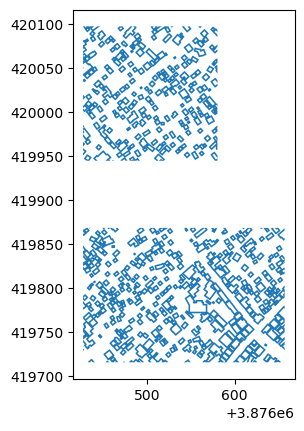

In [ ]:
valid_merges_gdf.plot()

In [ ]:
gdf_poly_060_filtered.head(5)

,index,geometry
1,1,"POLYGON ((3876483.894 419716.377, 3876484.191 ..."
4,4,"POLYGON ((3876489.395 419718.367, 3876495.096 ..."
7,7,"POLYGON ((3876472.218 419729.926, 3876472.943 ..."
9,9,"POLYGON ((3876461.704 419733.795, 3876465.512 ..."
12,12,"POLYGON ((3876469.273 419733.303, 3876469.805 ..."


<Axes: >

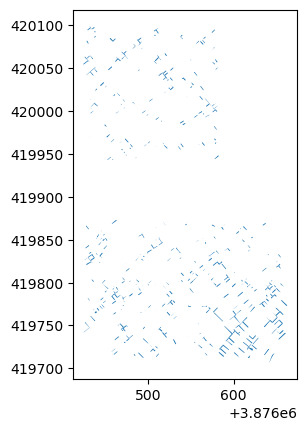

In [ ]:
gdf_poly_060_filtered.plot()

In [ ]:
res_symdiff = valid_merges_gdf.overlay(gdf_poly_060_filtered, how='symmetric_difference')

In [ ]:
data_path = os.path.join(root_folder, working_folder)

file_name9 = "gdf_building_boundary.geojson"

file_path9 = os.path.join(data_path, file_name9)

print(file_path9)

Omdena/__HOTOSM/Code\MultiMask_20240804\gdf_building_boundary.geojson


In [ ]:
#exporting the file:
#res_symdiff.to_file(file_path9, driver='GeoJSON')

In [ ]:
res_symdiff.head(5)

,label_status,label_fetched,created_at,last_modified,dataset,label_status_1,label_fetched_1,created_at_1,last_modified_1,dataset_1,OSM_ID_1,label_status_2,label_fetched_2,created_at_2,last_modified_2,dataset_2,OSM_ID_2,index,geometry
0,1.0,2024-04-29 12:39:43.536000+00:00,2024-01-16 12:26:35.812000+00:00,2024-04-29 12:39:43.536000+00:00,58.0,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,"MULTIPOLYGON (((3876431.415 419955.834, 387643..."
1,1.0,2024-01-23 12:35:50.990000+00:00,2024-01-23 12:35:41.883000+00:00,2024-01-23 12:35:50.990000+00:00,58.0,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,"MULTIPOLYGON (((3876428.564 419730.212, 387642..."
2,NaN,NaT,NaT,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,1.0,"POLYGON ((3876485.319 419715.173, 3876485.352 ..."
3,NaN,NaT,NaT,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,4.0,"POLYGON ((3876495.096 419712.590, 3876495.135 ..."
4,NaN,NaT,NaT,NaT,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,33.0,"POLYGON ((3876509.987 419713.192, 3876509.898 ..."


In [ ]:

#geometry
# List of columns to keep
columns_to_keep = ['geometry']

# Drop the columns not in the list
res_symdiff = res_symdiff[columns_to_keep]

res_symdiff.reset_index(inplace=True)

# Add a new column with a default value
res_symdiff['PolyType'] = "border"


# Display the resulting dataframe
print(len(res_symdiff))
res_symdiff.head(5)

#border polygons (with contact removed)

42


,index,geometry,PolyType
0,0,"MULTIPOLYGON (((3876431.415 419955.834, 387643...",border
1,1,"MULTIPOLYGON (((3876428.564 419730.212, 387642...",border
2,2,"POLYGON ((3876485.319 419715.173, 3876485.352 ...",border
3,3,"POLYGON ((3876495.096 419712.590, 3876495.135 ...",border
4,4,"POLYGON ((3876509.987 419713.192, 3876509.898 ...",border


In [ ]:
# Add a new column with a default value
gdf_poly_footprint['PolyType'] = "footprint"

gdf_poly_footprint.head(5)

,OSM_ID,geometry,PolyType
0,698353461,"POLYGON ((3876435.555 419716.179, 3876437.055 ...",footprint
1,698526227,"POLYGON ((3876486.012 419715.940, 3876487.657 ...",footprint
2,698526228,"POLYGON ((3876471.539 419726.529, 3876473.458 ...",footprint
3,698526229,"POLYGON ((3876463.775 419733.168, 3876465.729 ...",footprint
4,698526230,"POLYGON ((3876471.517 419733.438, 3876474.660 ...",footprint


In [ ]:
gdf_contact = gdf_poly_060_filtered.copy()

In [ ]:
# Add a new column with a default value
gdf_contact['PolyType'] = "contact"

# dissolve the state boundary by region
gdf_contact = gdf_contact.dissolve()

gdf_contact = gdf_contact.explode(index_parts=False)

gdf_contact.reset_index(inplace=True)
columns_to_drop = ['level_0', 'index']

# Drop the columns
gdf_contact = gdf_contact.drop(columns=columns_to_drop)

gdf_contact.reset_index(inplace=True)
gdf_contact.head(5)

,index,PolyType,geometry
0,0,contact,"POLYGON ((3876425.662 419742.092, 3876425.611 ..."
1,1,contact,"POLYGON ((3876433.620 419745.656, 3876432.000 ..."
2,2,contact,"POLYGON ((3876431.959 419747.486, 3876431.953 ..."
3,3,contact,"POLYGON ((3876438.138 419755.045, 3876438.079 ..."
4,4,contact,"POLYGON ((3876439.680 419766.449, 3876439.739 ..."


In [ ]:
res_intersection

,label_status_1,label_fetched_1,created_at_1,last_modified_1,dataset_1,OSM_ID,label_status_2,label_fetched_2,created_at_2,last_modified_2,dataset_2,geometry
0,1.0,2024-04-29 12:39:43.536000+00:00,2024-01-16 12:26:35.812000+00:00,2024-04-29 12:39:43.536000+00:00,58.0,NaN,1,2024-04-29 12:39:43.536000+00:00,2024-01-16 12:26:35.812000+00:00,2024-04-29 12:39:43.536000+00:00,58,"MULTIPOLYGON (((3876578.921 420008.752, 387657..."
1,1.0,2024-01-23 12:35:50.990000+00:00,2024-01-23 12:35:41.883000+00:00,2024-01-23 12:35:50.990000+00:00,58.0,NaN,1,2024-01-23 12:35:50.990000+00:00,2024-01-23 12:35:41.883000+00:00,2024-01-23 12:35:50.990000+00:00,58,"MULTIPOLYGON (((3876653.797 419756.519, 387665..."


In [ ]:
# Drop the columns not in the list
res_intersection = res_intersection[columns_to_keep].copy()

res_intersection.reset_index(inplace=True)

# Add a new column with a default value
res_intersection['PolyType'] = "outside"


# Display the resulting dataframe
print(len(res_intersection))
res_intersection.head(5)

#outside polygon

2


,index,geometry,PolyType
0,0,"MULTIPOLYGON (((3876578.921 420008.752, 387657...",outside
1,1,"MULTIPOLYGON (((3876653.797 419756.519, 387665...",outside


In [ ]:
# Combine the dataframes
combined_df = pd.concat([res_intersection, res_symdiff, gdf_contact, gdf_poly_footprint], ignore_index=True)

# Display the resulting dataframe
# List of columns to drop
columns_to_drop = ['index']

# Drop the columns
combined_df = combined_df.drop(columns=columns_to_drop)

# Display the resulting dataframe
combined_df

,geometry,PolyType,OSM_ID
0,"MULTIPOLYGON (((3876578.921 420008.752, 387657...",outside,NaN
1,"MULTIPOLYGON (((3876653.797 419756.519, 387665...",outside,NaN
2,"MULTIPOLYGON (((3876431.415 419955.834, 387643...",border,NaN
3,"MULTIPOLYGON (((3876428.564 419730.212, 387642...",border,NaN
4,"POLYGON ((3876485.319 419715.173, 3876485.352 ...",border,NaN
...,...,...,...
1027,"POLYGON ((3876634.628 419775.490, 3876635.588 ...",footprint,1.205464e+09
1028,"POLYGON ((3876497.278 420052.968, 3876500.728 ...",footprint,1.221945e+09
1029,"POLYGON ((3876504.630 420057.005, 3876505.848 ...",footprint,1.221945e+09
1030,"POLYGON ((3876509.825 420057.991, 3876512.264 ...",footprint,1.221945e+09


In [ ]:
# Explode MultiPolygons into individual Polygons
gdf_exploded = combined_df.explode(index_parts=False)

# Filter to keep only Polygons
gdf_polygons = gdf_exploded[gdf_exploded.geometry.type == 'Polygon']

# Display the resulting GeoDataFrame
gdf_polygons.reset_index(inplace=True)
print(len(gdf_polygons))
gdf_polygons.head(5)

1712


,index,PolyType,OSM_ID,geometry
0,0,outside,NaN,"POLYGON ((3876578.921 420008.752, 3876578.937 ..."
1,0,outside,NaN,"POLYGON ((3876433.189 419997.053, 3876433.223 ..."
2,0,outside,NaN,"POLYGON ((3876580.327 419966.850, 3876580.327 ..."
3,0,outside,NaN,"POLYGON ((3876580.327 419963.278, 3876580.235 ..."
4,0,outside,NaN,"POLYGON ((3876523.790 420097.907, 3876523.764 ..."


In [ ]:
data_path = os.path.join(root_folder, working_folder)

file_name10 = "gdf_multiclass_mask.geojson"

file_path10 = os.path.join(data_path, file_name10)

print(file_path10)

Omdena/__HOTOSM/Code\MultiMask_20240804\gdf_multiclass_mask.geojson


In [ ]:
# Exporting the file:
#gdf_polygons.to_file(file_path10, driver='GeoJSON')